# New York City Taxi Trip Duration

Share code and data to improve ride time predictions

## Contents

1. EDA
  1. 데이터 확인
  1. Correlation 분석
      1. heatmap
      1. pairplot
      1. VIF
1. rough modeling
  - 결과 진단
      1. 잔차 정규성 검정
          - plot (residual - feature)
      1. 이분산 검정
          - scatter plot (residual - feature)
      1. 자기상관 검정
          - PCA 결정
      1. target-feature check
          1. partial regression plot
          1. ccpr plot
1. 컬럼별 최적 정규화
1. modeling
  1. model with outlier
  1. model w/o outlier
  1. 결과 진단
      1. 잔차 정규성 검정
      1. 이분산 검정
      1. 자기상관 검정
      1. target-feature check
1. Cross validation 결과
1. Kaggle 결과
1. 결론

---

In [1]:
from taxi_pakage import *
%matplotlib inline

---

# 1. EDA

## A. Data check

In [2]:
taxi = pd.read_csv('train.csv')
taxi.tail()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
1458639,id2376096,2,2016-04-08 13:31:04,2016-04-08 13:44:02,4,-73.982201,40.745522,-73.994911,40.740170,N,778
1458640,id1049543,1,2016-01-10 07:35:15,2016-01-10 07:46:10,1,-74.000946,40.747379,-73.970184,40.796547,N,655
1458641,id2304944,2,2016-04-22 06:57:41,2016-04-22 07:10:25,1,-73.959129,40.768799,-74.004433,40.707371,N,764
1458642,id2714485,1,2016-01-05 15:56:26,2016-01-05 16:02:39,1,-73.982079,40.749062,-73.974632,40.757107,N,373
1458643,id1209952,1,2016-04-05 14:44:25,2016-04-05 14:47:43,1,-73.979538,40.781750,-73.972809,40.790585,N,198


In [3]:
# 데이터 크기
taxi.shape

(1458644, 11)

In [4]:
# 데이터에 대한 정보 (컬럼 개수, null값 여부, 데이터 유형)
taxi.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


- object : id, pickup_datetime, dropoff_datetime, store_and_fwd_flag
- int : vendor_id, passenger_count, trip_duration
- float : pickup_logitude, pickup_latitude, dropoff_logitude, dropoff_latitude

| Values | Meaning |
|-|-|
|id | a unique identifier for each trip |
|vendor_id | a code indicating the provider associated with the trip record |
|pickup_datetime|date and time when the meter was engaged |
|dropoff_datetime|date and time when the meter was disengaged|
|passenger_count|the number of passengers in the vehicle (driver entered value)|
|pickup_longitude|the longitude where the meter was engaged|
|pickup_latitude| the latitude where the meter was engaged|
|dropoff_longitude| the longitude where the meter was disngaged|
|dropoff_latitude| the latitude where the meter was disengaged|
|store_and_fwd_flag|This indicates whether the trip record was held in vehicle memory |
|trip_duration|duration of the trip in seconds|

In [5]:
taxi.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


### 데이터 분포 
- vendor_id
- passenger_count
- store_and_fwd_flag

/home/mk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


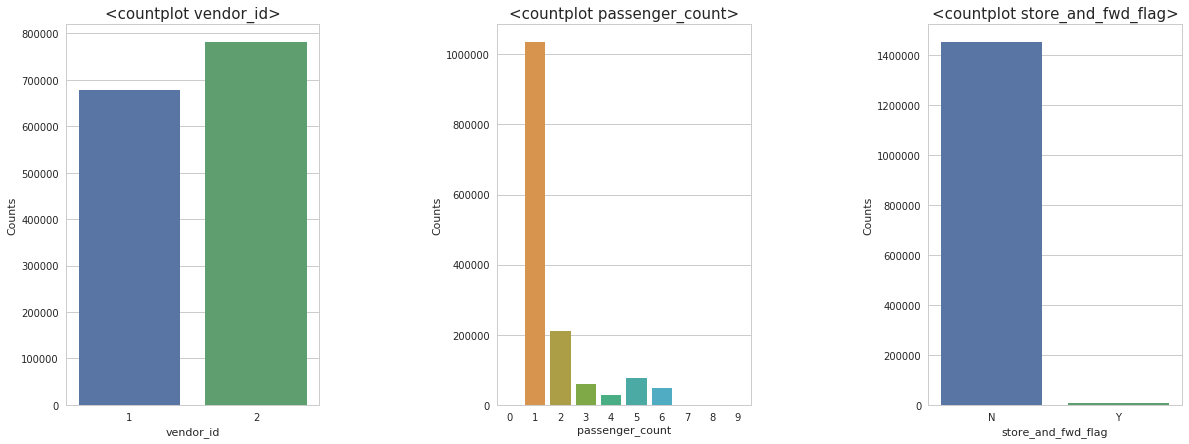

In [6]:
# countplot
plt.figure(figsize=(20, 7))
plt.subplots_adjust(wspace = 0.7)

# vendor_id
plt.subplot(131)
sns.countplot(x = 'vendor_id', data = taxi)
plt.title('<countplot vendor_id>', fontsize = 15)
plt.xlabel('vendor_id')
plt.ylabel('Counts')

# passenger_count
plt.subplot(132)
sns.countplot(x = 'passenger_count', data = taxi)
plt.title('<countplot passenger_count>', fontsize = 15)
plt.xlabel('passenger_count')
plt.ylabel('Counts')

# store_and_fwd_flag
plt.subplot(133)
sns.countplot(x = 'store_and_fwd_flag', data = taxi)
plt.title('<countplot store_and_fwd_flag>', fontsize = 15)
plt.xlabel('store_and_fwd_flag')
plt.ylabel('Counts')

plt.show()

/home/mk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


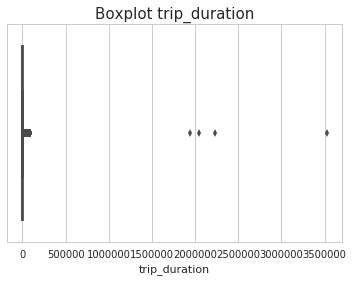

In [7]:
# Trip_druation
sns.boxplot(x = 'trip_duration', data = taxi)
plt.title('Boxplot trip_duration', fontsize = 15)
plt.xlabel('trip_duration')

plt.show()

In [8]:
# 이상치 체크
taxi[taxi['trip_duration'] > 1500000]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
355003,id1864733,1,2016-01-05 00:19:42,2016-01-27 11:08:38,1,-73.789650,40.643559,-73.956810,40.773087,N,1939736
680594,id0369307,1,2016-02-13 22:38:00,2016-03-08 15:57:38,2,-73.921677,40.735252,-73.984749,40.759979,N,2049578
924150,id1325766,1,2016-01-05 06:14:15,2016-01-31 01:01:07,1,-73.983788,40.742325,-73.985489,40.727676,N,2227612
978383,id0053347,1,2016-02-13 22:46:52,2016-03-25 18:18:14,1,-73.783905,40.648632,-73.978271,40.750202,N,3526282


In [5]:
# Trip_duration에서 나타난 4개의 이상치 제거
taxi = taxi[taxi['trip_duration'] < 1500000].reset_index(drop=True)

/home/mk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


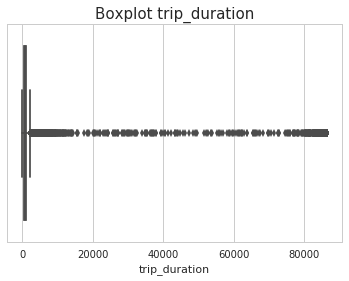

In [12]:
# Trip_druation
sns.boxplot(x = 'trip_duration', data = taxi)
plt.title('Boxplot trip_duration', fontsize = 15)
plt.xlabel('trip_duration')

plt.show()

### 데이터 분포
- locations
- trip_duration

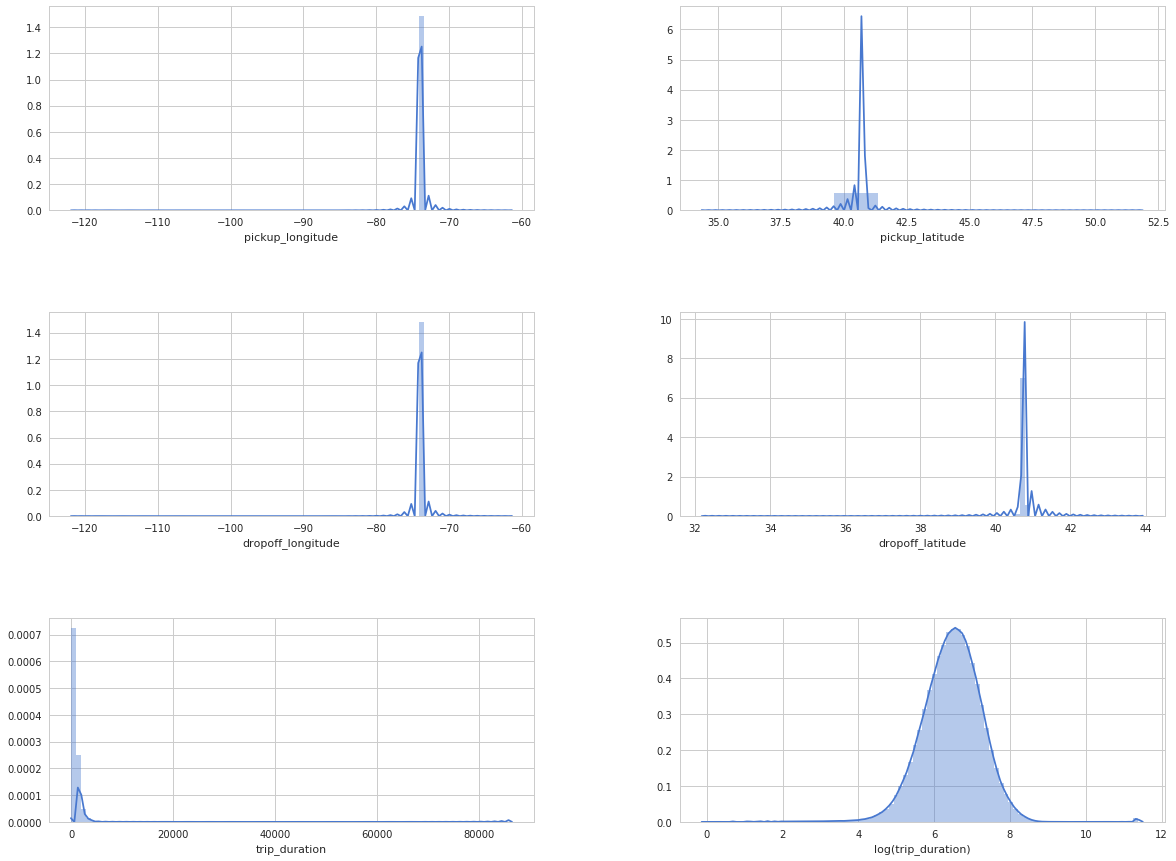

In [6]:
# normal distribution
plt.figure(figsize=(20, 15))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

# pickup_longitude
plt.subplot(321)
sns.distplot(taxi["pickup_longitude"].values, 
             axlabel = "pickup_longitude", label = "pickup_longitude", bins = 90, color = "b")

# pickup_latitude
plt.subplot(322)
sns.distplot(taxi["pickup_latitude"].values, 
             axlabel = "pickup_latitude", label = "pickup_latitude", bins = 10, color = "b")

# dropoff_longitude
plt.subplot(323)
sns.distplot(taxi["dropoff_longitude"].values, 
             axlabel = "dropoff_longitude", label = "dropoff_longitude", bins = 90, color = "b")

# dropoff_latitude
plt.subplot(324)
sns.distplot(taxi["dropoff_latitude"].values, 
             axlabel = "dropoff_latitude", label = "dropoff_latitude", bins = 90, color = "b")

# trip_duration
plt.subplot(325)
sns.distplot(taxi["trip_duration"].values,
             axlabel = "trip_duration", label = "trip_duration", bins = 90, color = "b")

plt.subplot(326)
sns.distplot(np.log(taxi["trip_duration"]).values, 
             axlabel = "log(trip_duration)", label = "trip_duration", bins = 90, color = "b")

plt.show()

### pickup, dropoff location

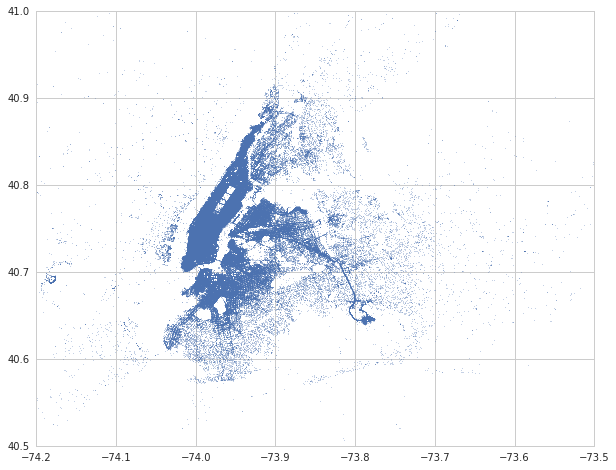

In [14]:
longitude = list(taxi['pickup_longitude']) + list(taxi['dropoff_longitude'])
latitude = list(taxi['pickup_latitude']) + list(taxi['dropoff_latitude'])
plt.figure(figsize = (10, 8))
plt.xlim(-74.2, -73.5)
plt.ylim(40.5, 41)
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 1.5)
plt.show()

### edit data

In [5]:
# id 숫자화 - 분석을 위해 숫자화
taxi['id'] = taxi['id'].apply(lambda x: int(x[2:]))

# store_and_fwd_flag -  N, Y 를 0, 1 숫자로 변경
taxi['store_and_fwd_flag'] = taxi['store_and_fwd_flag'].apply(lambda x: 0 if x == 'N' else 1)

# pickup_datetime, dropoff_datetime 형식 바꿈 (2016.01.01 기준)
taxi['pickup_datetime'] = taxi['pickup_datetime'].apply(strptime)
# taxi['dropoff_datetime'] = taxi['dropoff_datetime'].apply(strptime) 어차피 test에는 없는 데이터

In [6]:
# 좌표를 이용해 직선 거리 계산
taxi['dist'] = haversine_np(taxi['pickup_longitude'], taxi['pickup_latitude'], 
                            taxi['dropoff_longitude'], taxi['dropoff_latitude'])
# date를 세분화
taxi['pick_date'] = taxi['pickup_datetime'].apply(date_to_zero)
taxi['pick_time'] = taxi['pickup_datetime'].apply(time_to_zero)

# 요일 표시 (1:월, 2:화, 3:수, 4:목, 5:금, 6:토, 7:일)
taxi['weekday'] = taxi['pickup_datetime'].apply(week_num)

# holiday: 휴일(1) 평일(0) 
taxi['holiday'] = taxi['pickup_datetime'].apply(holiday)

In [8]:
# 최종 데이터
# 차후 분석을 위해 연속형 데이터, 카테고리 데이터, y(trip_duration)순으로 재배치
x_1 = taxi['vendor_id']
x_2 = taxi['passenger_count']
x_3 = taxi['store_and_fwd_flag']
y = taxi['trip_duration'] 

taxi = taxi.drop(['vendor_id', 'passenger_count' , 'store_and_fwd_flag', 'pickup_datetime', 'dropoff_datetime', 'trip_duration'], axis = 1)

taxi['vendor_id'] = x_1
taxi['passenger_count'] = x_2
taxi['store_and_fwd_flag'] = x_3 
taxi['trip_duration'] = y
taxi.tail()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,pick_date,pick_time,weekday,holiday,vendor_id,passenger_count,store_and_fwd_flag,trip_duration
1458635,2376096,-73.982201,40.745522,-73.994911,40.740170,1.224311,98,48663,5,0,2,4,0,778
1458636,1049543,-74.000946,40.747379,-73.970184,40.796547,6.046037,9,27314,7,0,1,1,0,655
1458637,2304944,-73.959129,40.768799,-74.004433,40.707371,7.819693,112,25060,5,0,2,1,0,764
1458638,2714485,-73.982079,40.749062,-73.974632,40.757107,1.091878,4,57385,2,0,1,1,0,373
1458639,1209952,-73.979538,40.781750,-73.972809,40.790585,1.133330,95,53064,2,0,1,1,0,198


## new features check
- dist, pick_date, pick_time, weekday, holiday

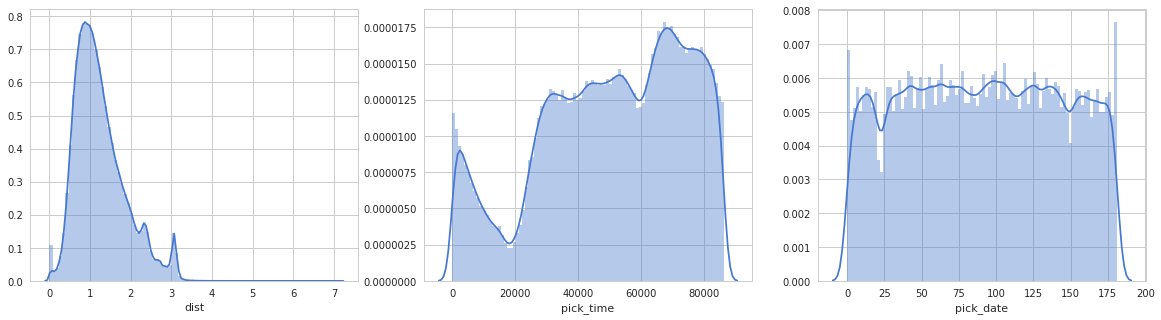

In [25]:
plt.figure(figsize=(20, 5))
plt.subplots_adjust(wspace = 0.2)

plt.subplot(131)
sns.distplot(np.log1p(taxi["dist"]).values, 
             axlabel = "dist", label = "dist", bins = 90, color = "b")

plt.subplot(132)
sns.distplot(taxi["pick_time"].values, 
             axlabel = "pick_time", label = "pick_time", bins = 90, color = "b")

plt.subplot(133)
sns.distplot(taxi["pick_date"].values, 
             axlabel = "pick_date", label = "pick_date", bins = 90, color = "b")

plt.show()

/home/mk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:1460: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  stat_data = remove_na(group_data)


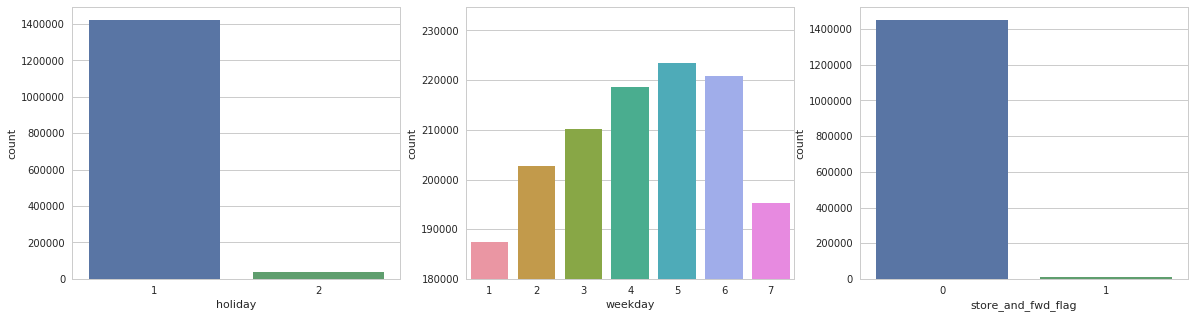

In [23]:
plt.figure(figsize=(20, 5))
plt.subplots_adjust(wspace = 0.2)

plt.subplot(131)
sns.countplot(x = 'holiday', data = taxi)
plt.xlabel('holiday')

plt.subplot(132)
sns.countplot(x = 'weekday', data = taxi)
plt.xlabel('weekday')
plt.ylim(180000)

plt.subplot(133)
sns.countplot(x = 'store_and_fwd_flag', data = taxi)
plt.xlabel('store_and_fwd_flag')

plt.show()

/home/mk/anaconda3/lib/python3.6/site-packages/seaborn/categorical.py:462: FutureWarning: remove_na is deprecated and is a private function. Do not use.
  box_data = remove_na(group_data)


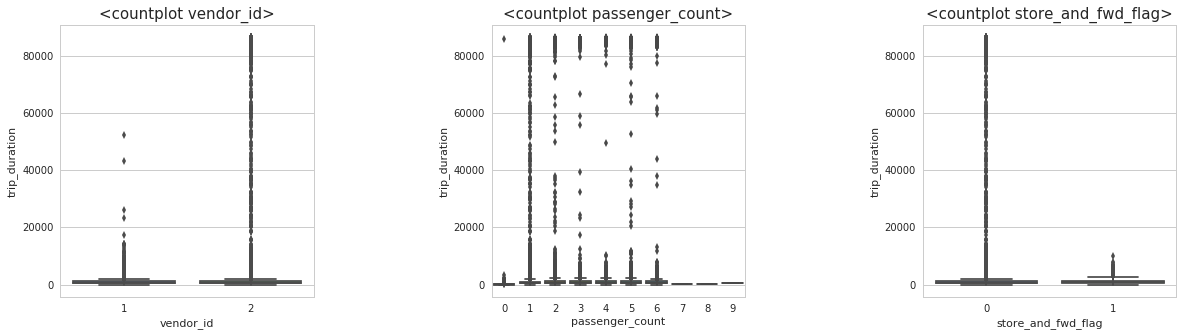

In [27]:
# countplot
plt.figure(figsize=(20, 5))
plt.subplots_adjust(wspace = 0.7)

# vendor_id
plt.subplot(131)
sns.boxplot(x = 'vendor_id', y = 'trip_duration', data = taxi)
plt.title('<countplot vendor_id>', fontsize = 15)
plt.xlabel('vendor_id')
plt.ylabel('trip_duration')

# passenger_count
plt.subplot(132)
sns.boxplot(x = 'passenger_count', y = 'trip_duration', data = taxi)
plt.title('<countplot passenger_count>', fontsize = 15)
plt.xlabel('passenger_count')
plt.ylabel('trip_duration')

# store_and_fwd_flag
plt.subplot(133)
sns.boxplot(x = 'store_and_fwd_flag', y = 'trip_duration', data = taxi)
plt.title('<countplot store_and_fwd_flag>', fontsize = 15)
plt.xlabel('store_and_fwd_flag')
plt.ylabel('trip_duration')

plt.show()

## B. Correlation check

### a. heatmap

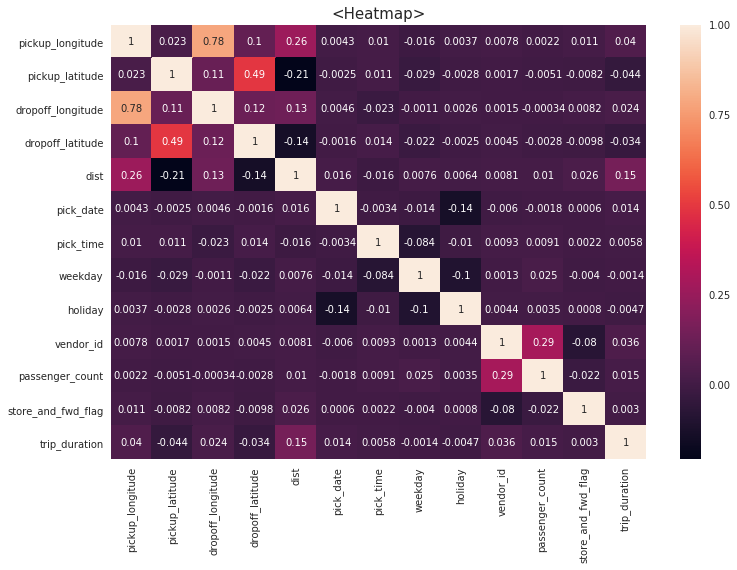

In [29]:
f, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(taxi.corr(), annot=True)
plt.title("<Heatmap>", fontsize = 15)
plt.show()

### b. pairplot

**상관관계 높은 몇개만 해주세요 **

In [ ]:
# 오래 걸려서 일단 패스
# taxi_pair = taxi.drop(['vendor_id', 'passenger_count', 'store_and_fwd_flag', 'pick_time', 'drop_time'], axis = 1)
# sns.pairplot(taxi)

### c. VIF

** `id를 빼야 VIF가 먹는데 그 이유를 잘 모르겠습니다ㅜㅜ` ** 
- str -> int

In [9]:
# taxi_vif = taxi_EDA.drop(['id', 'trip_duration'], axis = 1)
taxi_vif = taxi.drop(['trip_duration'], axis=1)
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(taxi_vif.values, i) for i in range(taxi_vif.shape[1])]
vif["features"] = taxi_vif.columns
vif

,VIF Factor,features
0,3.996911,id
1,2.692744,pickup_longitude
2,1.095152,pickup_latitude
3,2.494935,dropoff_longitude
4,1.145921,dropoff_latitude
5,1.043282,dist
6,1.020980,pick_date
7,1.010715,pick_time
8,1.021052,weekday
9,1.031888,holiday


---

# 2. Rough modeling

In [10]:
feature_n, features = get_features(taxi, 0, -1)
feature_n, features

(13,
 'id + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + dist + pick_date + pick_time + weekday + holiday + vendor_id + passenger_count + store_and_fwd_flag')

In [11]:
model =  sm.OLS.from_formula("trip_duration ~ {}".format(features), data = taxi)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     2852.
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        22:26:26   Log-Likelihood:            -1.3811e+07
No. Observations:             1458640   AIC:                         2.762e+07
Df Residuals:                 1458626   BIC:                         2.762e+07
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept           8.994e+04   5102.752     17.625      0.000    7.99e+04    9.99e+04
id                 -2.042e-06   2.25e-06     -0.909      0.363   -6.44e-06    2.36e-06
pickup_longitude    -316.1917     61.212     -5.166      0.000    -436.164    -196.219
pickup_latitude     -942.5091     92.676    -10.170      0.000   -1124.151    -760.867
dropoff_longitude    555.3984     60.131      9.236      0.000     437.543     673.254
dropoff_latitude    -826.8351     83.790     -9.868      0.000    -991.060    -662.610
dist                 109.5792      0.646    169.546      0.000     108.312     110.846
pick_date              0.6534      0.051     12.859      0.000       0.554       0.753
pick_time              0.0011      0.000      9.972      0.000       0.001       0.001
weekday               -4.7229      1.341     -3.522      0.000      -7.352      -2.094
holiday              -94.0147     16.896     -5.564      0.000    -127.131     -60.899
vendor_id            215.0759      5.445     39.501      0.000     204.404     225.748
passenger_count        8.3990      2.061      4.075      0.000       4.360      12.438
store_and_fwd_flag    70.8773     35.140      2.017      0.044       2.005     139.750
==============================================================================
Omnibus:                  3542540.197   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      29872080056.969
Skew:                          25.984   Prob(JB):                         0.00
Kurtosis:                     702.146   Cond. No.                     4.54e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.54e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## A. 잔차 정규성 검정

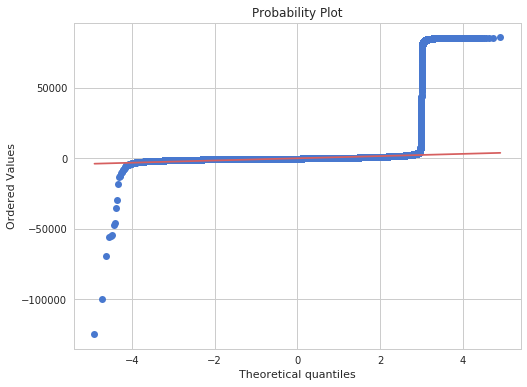

In [33]:
# probplot
f, ax = plt.subplots(figsize=(8, 6))
sp.stats.probplot(result.resid, plot = plt)
plt.show()

In [12]:
# Resid test1 
test_resid1 = sms.omni_normtest(result.resid)
for xi in zip(['Chi^2', 'P-value'], test_resid1):
    print("%-12s: %6.3f" % xi)

Chi^2       : 3542540.197
P-value     :  0.000


In [13]:
# Resid test2     
test_resid2 = sms.jarque_bera(result.resid)
for xi in zip(['Jarque-Bera', 'P-value', 'Skew', 'Kurtosis'], test_resid2):
    print("%-12s: %6.3f" % xi)

Jarque-Bera : 29872080056.969
P-value     :  0.000
Skew        : 25.984
Kurtosis    : 702.146


In [ ]:
# x값에 따른 잔차의 분포 
plt.plot(taxi, result.resid, 'o')
plt.axhline(y=0, c='k')
plt.ylabel("Residual")
plt.show()

#### 잔차 - 독립 변수간 관계 체크
- 특별한 선형/비선형 관계는 보이지 않음

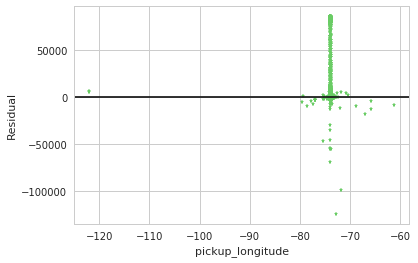

In [21]:
plt.plot(taxi['pickup_longitude'], result.resid, 'g*', markersize=5)
plt.axhline(y=0, c='k')
plt.xlabel("pickup_longitude")
plt.ylabel("Residual")
plt.show()

## B. 이분산 검정

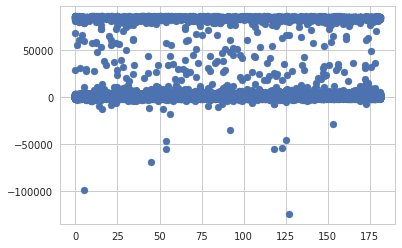

In [22]:
plt.scatter(taxi['pick_date'], result.resid)
plt.show()

## C. 자기상관 검정

#### Durbin-Watson 검정
값이 2 -> 무상관

In [15]:
durbin_watson(result.wresid)

2.0001742451846138

## D. Target-feature check

#### partial regression 

In [20]:
fig = plt.figure(figsize=(20, 40))
sm.graphics.plot_partregress_grid(result, fig=fig)
plt.show()

#### ccpr
- 그림이 개똥이네요;

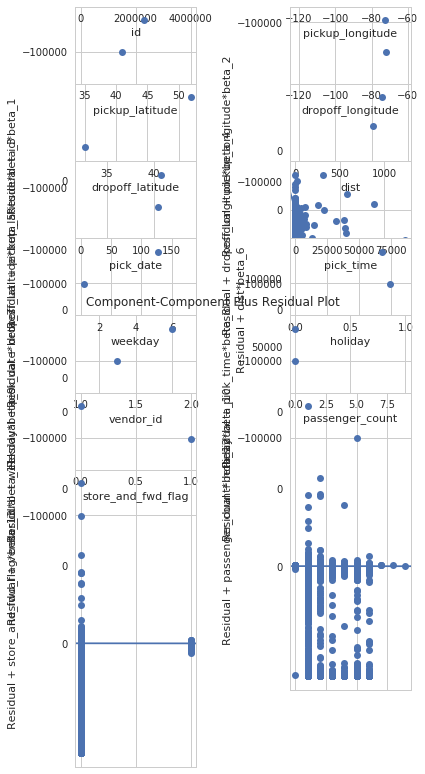

In [31]:
sm.graphics.plot_ccpr_grid(result) 
plt.show()

---

# 3. Optimal regulize

각 컬럼별 최적 정규화
- 의미가 없는 경우 제거

1. id
1. vendor_id
1. passenger_count
1. store_and_fwd_flag
1. locations
1. dist
1. pick_date
1. pick_time
1. weekday
1. holiday


---

## 3.1 Leverage (레버리지)

In [14]:
# (시간이 걸려서 일단 패스)
# influence = result.get_influence()
# hat = influence.hat_matrix_diag

# plt.figure(figsize = (10, 2))
# plt.stem(hat)
# plt.show()

## 3.2 Outlier (아웃라이어)

In [16]:
taxi_2, drop = erase_outlier_np(result_1, taxi_1, feature_n, dropped=True)
len(taxi_1), len(drop)

(1458644, 2318)

In [17]:
feature_n_2, features_2 = get_features(taxi_1, 1, -1)
feature_n_2, features_2

(14,
 'id + pickup_longitude + pickup_latitude + dropoff_longitude + dropoff_latitude + dist + pick_date + pick_time + drop_time + weekday + holiday + vendor_id + passenger_count + store_and_fwd_flag')

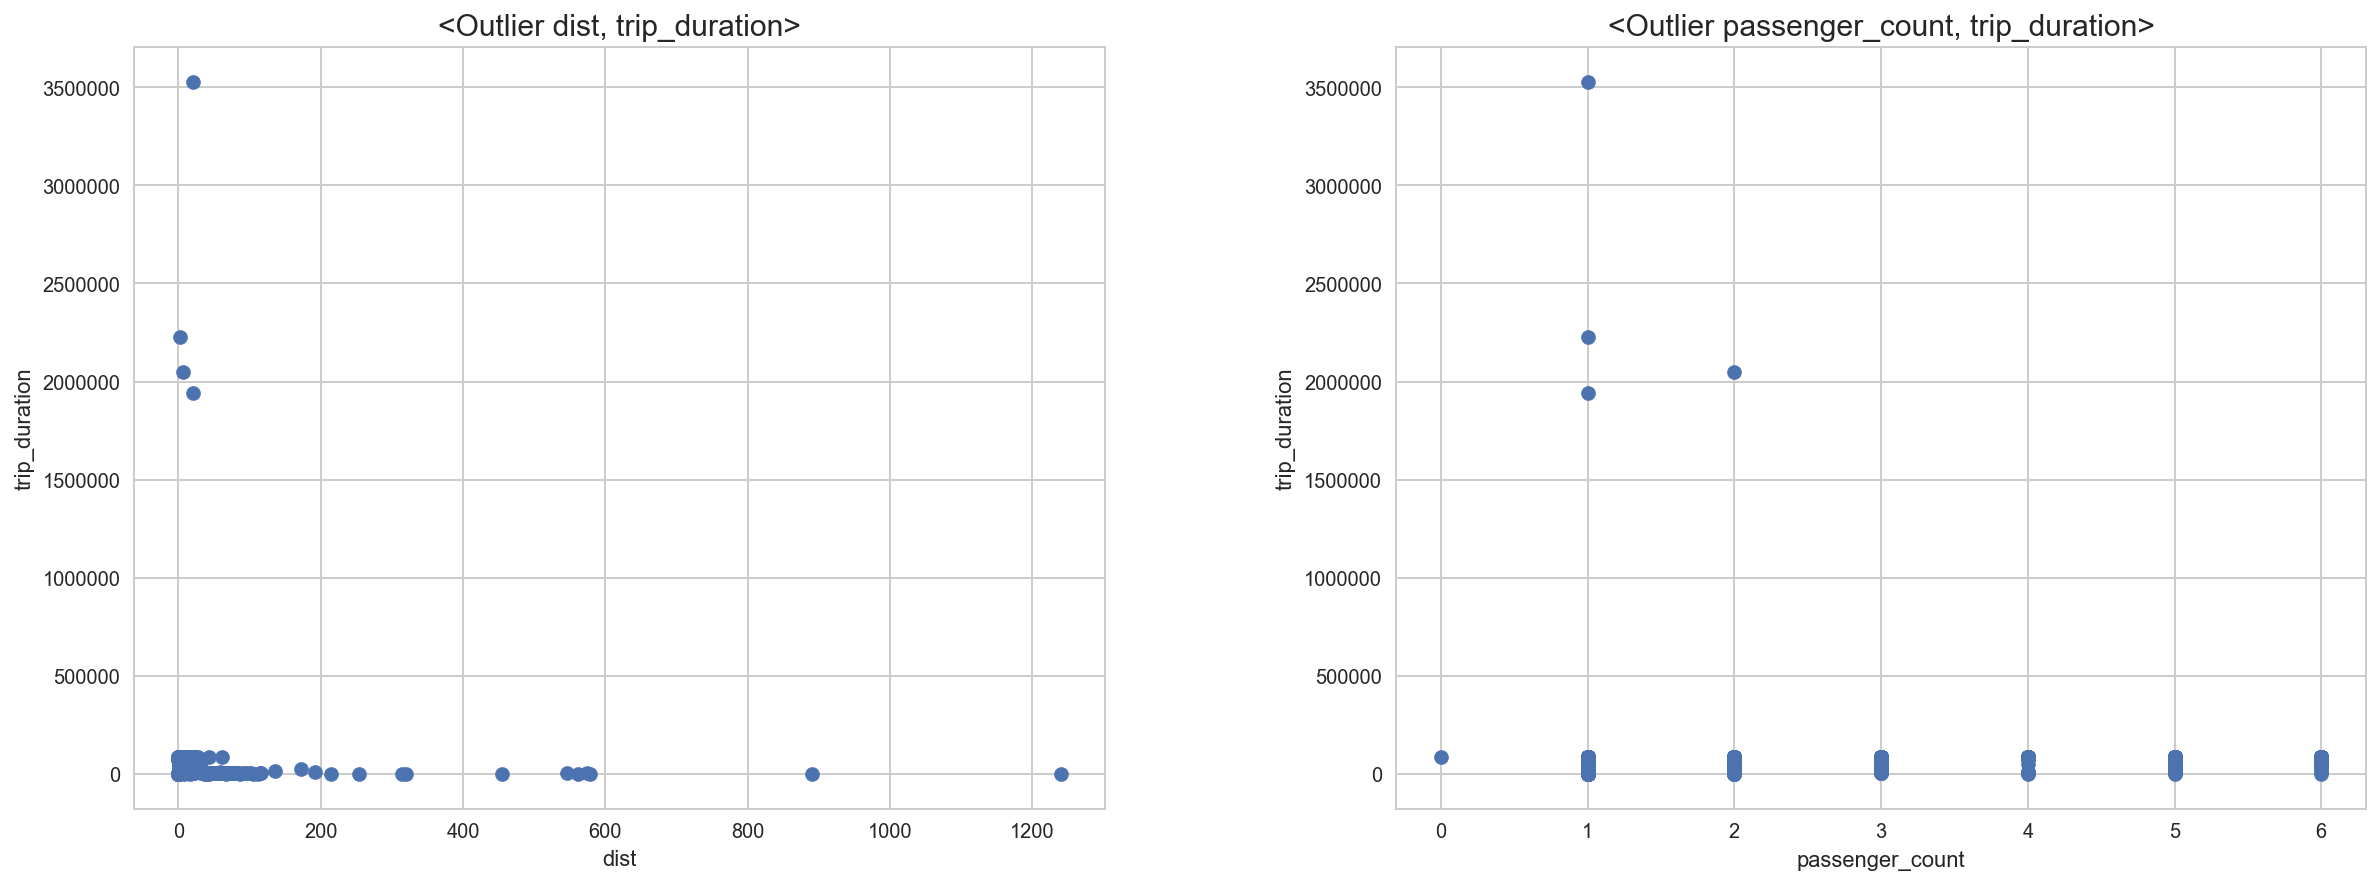

In [18]:
# Outlier
plt.figure(figsize = (20, 7))
plt.subplots_adjust(wspace = 0.3)

# outlier 제거 확인 (dist, trip_duration)
plt.subplot(121)
plt.scatter(drop['dist'], drop['trip_duration'])
plt.title('<Outlier dist, trip_duration>', fontsize = 15)
plt.xlabel('dist')
plt.ylabel('trip_duration')

# outlier 제거 확인 (passenger_count, trip_duration)
plt.subplot(122)
plt.scatter(drop['passenger_count'], drop['trip_duration'])
plt.title('<Outlier passenger_count, trip_duration>', fontsize = 15)
plt.xlabel('passenger_count')
plt.ylabel('trip_duration')

plt.show()

In [19]:
# 제거 후 결과
model_2 =  sm.OLS.from_formula("trip_duration ~ {}".format(features_1), data = taxi_2)
result_2 = model_2.fit()
result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 1.610e+05
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:42:46   Log-Likelihood:            -1.0833e+07
No. Observations:             1456326   AIC:                         2.167e+07
Df Residuals:                 1456311   BIC:                         2.167e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept          -9.844e+04   1292.164    -76.182      0.000   -1.01e+05   -9.59e+04
id                  6.053e-07   2.95e-07      2.050      0.040    2.65e-08    1.18e-06
pickup_longitude    -558.1743     10.494    -53.188      0.000    -578.743    -537.606
pickup_latitude     1017.6884     14.099     72.183      0.000     990.055    1045.322
dropoff_longitude   -934.2945     10.458    -89.337      0.000    -954.792    -913.797
dropoff_latitude   -1301.1687     11.931   -109.059      0.000   -1324.553   -1277.785
dist                 135.7249      0.112   1217.121      0.000     135.506     135.943
pick_date              0.5475      0.007     81.937      0.000       0.534       0.561
pick_time             -0.0016    4.1e-05    -38.693      0.000      -0.002      -0.002
drop_time              0.0029   4.05e-05     70.701      0.000       0.003       0.003
weekday              -13.4496      0.177    -76.195      0.000     -13.796     -13.104
holiday             -105.0081      2.222    -47.260      0.000    -109.363    -100.653
vendor_id              0.8521      0.716      1.190      0.234      -0.551       2.255
passenger_count        3.4683      0.271     12.791      0.000       2.937       4.000
store_and_fwd_flag    34.3560      4.627      7.426      0.000      25.288      43.424
==============================================================================
Omnibus:                   782315.469   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21436280.680
Skew:                           2.052   Prob(JB):                         0.00
Kurtosis:                      21.342   Cond. No.                     8.75e+09
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.75e+09. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## 3.3 Scaling (스케일링)

In [20]:
# Scaling을 위한 데이터 setting
taxi_3 = taxi_2
taxi_3.tail()

,Intercept,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,pick_date,pick_time,drop_time,weekday,holiday,vendor_id,passenger_count,store_and_fwd_flag,trip_duration
1456321,1.00,2376096.00,-73.98,40.75,-73.99,40.74,1.22,98.00,48663.00,49441.00,5.00,1.00,2.00,4.00,0.00,778.00
1456322,1.00,1049543.00,-74.00,40.75,-73.97,40.80,6.05,9.00,27314.00,27969.00,7.00,1.00,1.00,1.00,0.00,655.00
1456323,1.00,2304944.00,-73.96,40.77,-74.00,40.71,7.82,112.00,25060.00,25824.00,5.00,1.00,2.00,1.00,0.00,764.00
1456324,1.00,2714485.00,-73.98,40.75,-73.97,40.76,1.09,4.00,57385.00,57758.00,2.00,1.00,1.00,1.00,0.00,373.00
1456325,1.00,1209952.00,-73.98,40.78,-73.97,40.79,1.13,95.00,53064.00,53262.00,2.00,1.00,1.00,1.00,0.00,198.00


In [21]:
# Scale 부여
feature_n_3, features_3 = get_features(taxi_3, 1, -1, scale = True)
feature_n_3, features_3

(14,
 'scale(id) + scale(pickup_longitude) + scale(pickup_latitude) + scale(dropoff_longitude) + scale(dropoff_latitude) + scale(dist) + scale(pick_date) + scale(pick_time) + scale(drop_time) + scale(weekday) + scale(holiday) + scale(vendor_id) + scale(passenger_count) + scale(store_and_fwd_flag)')

In [22]:
# Scale data summary
model_3 =  sm.OLS.from_formula("trip_duration ~ {} ".format(features_3), data = taxi_3)
result_3 = model_3.fit()
result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          trip_duration   R-squared:                       0.608
Model:                            OLS   Adj. R-squared:                  0.608
Method:                 Least Squares   F-statistic:                 1.610e+05
Date:                Tue, 13 Mar 2018   Prob (F-statistic):               0.00
Time:                        16:47:01   Log-Likelihood:            -1.0833e+07
No. Observations:             1456326   AIC:                         2.167e+07
Df Residuals:                 1456311   BIC:                         2.167e+07
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                   836.3487      0.341   2452.675      0.000     835.680     837.017
scale(id)                     0.6989      0.341      2.050      0.040       0.031       1.367
scale(pickup_longitude)     -21.4611      0.403    -53.188      0.000     -22.252     -20.670
scale(pickup_latitude)       28.6855      0.397     72.183      0.000      27.907      29.464
scale(dropoff_longitude)    -33.7539      0.378    -89.337      0.000     -34.494     -33.013
scale(dropoff_latitude)     -42.1093      0.386   -109.059      0.000     -42.866     -41.352
scale(dist)                 531.1975      0.436   1217.121      0.000     530.342     532.053
scale(pick_date)             28.2329      0.345     81.937      0.000      27.558      28.908
scale(pick_time)            -36.5392      0.944    -38.693      0.000     -38.390     -34.688
scale(drop_time)             66.8134      0.945     70.701      0.000      64.961      68.666
scale(weekday)              -26.2805      0.345    -76.195      0.000     -26.957     -25.604
scale(holiday)              -16.3706      0.346    -47.260      0.000     -17.050     -15.692
scale(vendor_id)              0.4250      0.357      1.190      0.234      -0.275       1.125
scale(passenger_count)        4.5561      0.356     12.791      0.000       3.858       5.254
scale(store_and_fwd_flag)     2.5416      0.342      7.426      0.000       1.871       3.212
==============================================================================
Omnibus:                   782315.469   Durbin-Watson:                   2.000
Prob(Omnibus):                  0.000   Jarque-Bera (JB):         21436280.680
Skew:                           2.052   Prob(JB):                         0.00
Kurtosis:                      21.342   Cond. No.                         5.41
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## 3.4 변수변환

## 3.5 Multicollinearity (다중공선성)

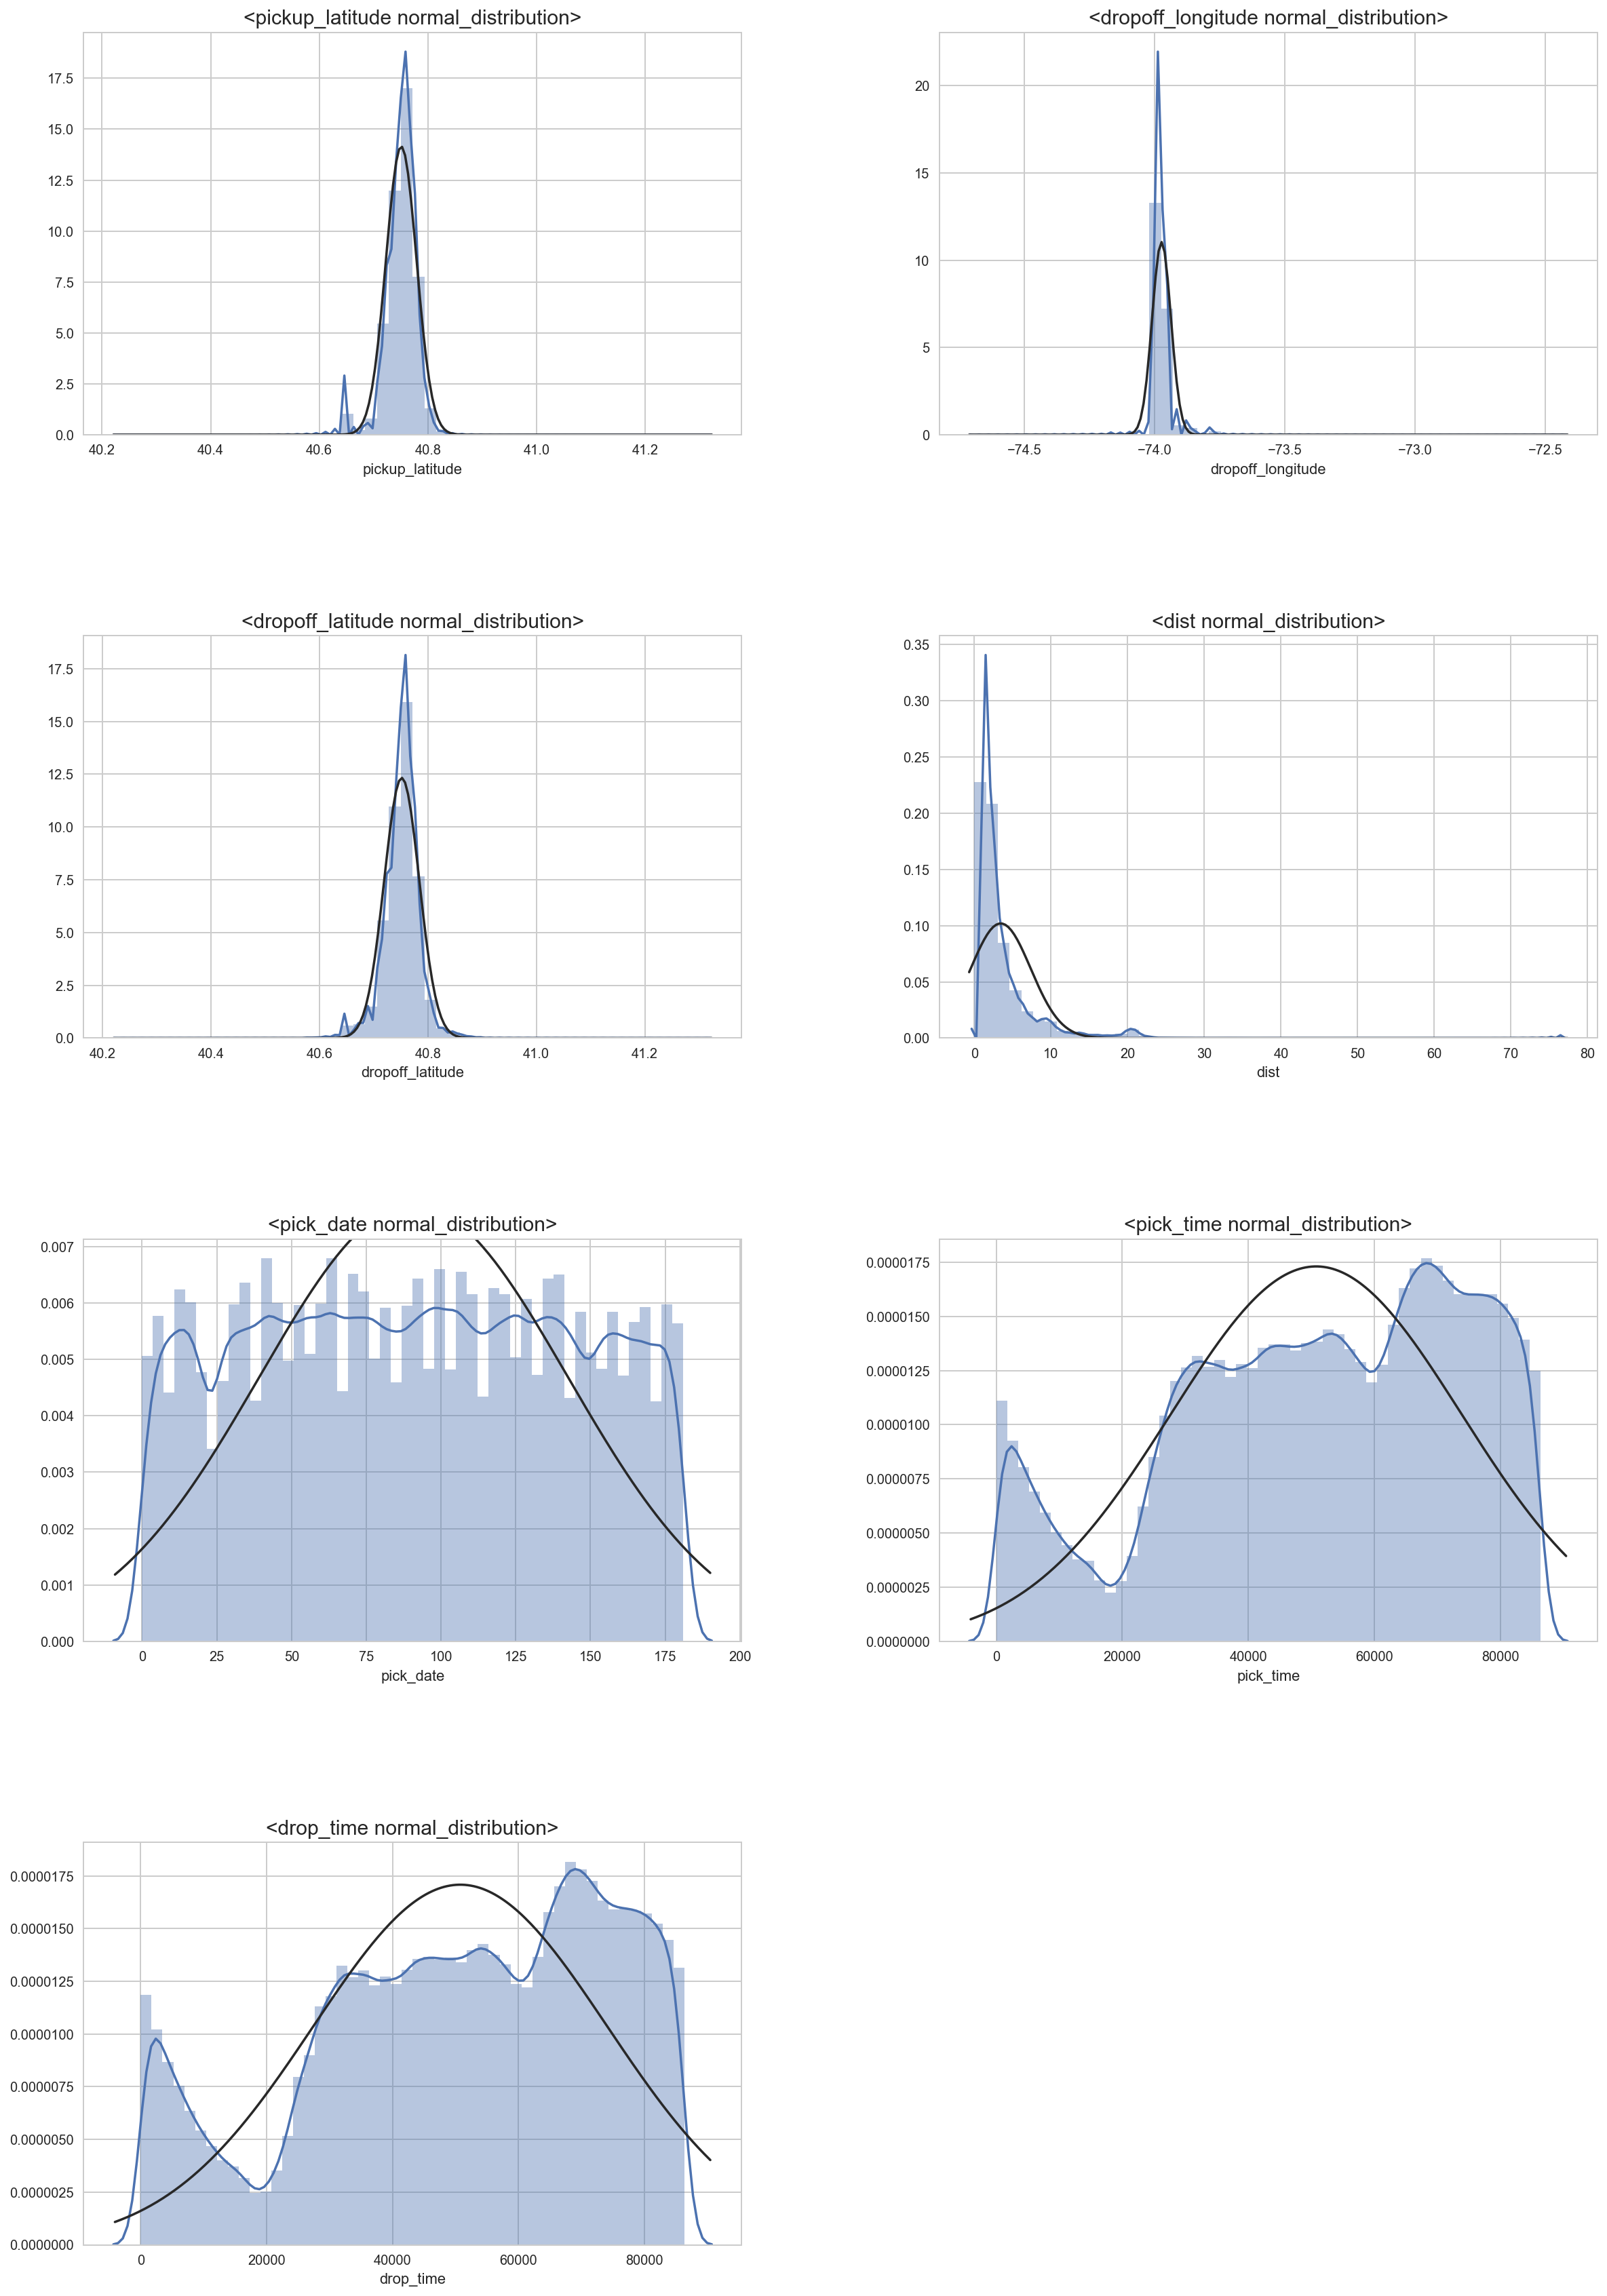

In [23]:
# 정규분포
plt.figure(figsize = (20, 30))
plt.subplots_adjust(hspace = 0.5, wspace = 0.3)

# pickup_latitude 정규분포
plt.subplot(421)
sns.distplot(taxi_3['pickup_latitude'], kde = True, fit=sp.stats.norm)
plt.title('<pickup_latitude normal_distribution>', fontsize = 15)

# dropoff_longitude 정규분포
plt.subplot(422)
sns.distplot(taxi_3['dropoff_longitude'], kde = True, fit=sp.stats.norm)
plt.title('<dropoff_longitude normal_distribution>', fontsize = 15)

# dropoff_latitude 정규분포
plt.subplot(423)
sns.distplot(taxi_3['dropoff_latitude'], kde = True, fit=sp.stats.norm)
plt.title('<dropoff_latitude normal_distribution>', fontsize = 15)

# dist 정규분포
plt.subplot(424)
sns.distplot(taxi_3['dist'], kde = True, fit=sp.stats.norm)
plt.title('<dist normal_distribution>', fontsize = 15)

# pick_date 정규분포
plt.subplot(425)
sns.distplot(taxi_3['pick_date'], kde = True, fit = sp.stats.norm)
plt.title('<pick_date normal_distribution>', fontsize = 15)

# pick_time 정규분포
plt.subplot(426)
sns.distplot(taxi_3['pick_time'], kde=True, fit = sp.stats.norm)
plt.title('<pick_time normal_distribution>', fontsize = 15)

# drop_time 정규분포
plt.subplot(427)
sns.distplot(taxi_3['drop_time'], kde = True, fit = sp.stats.norm)
plt.title('<drop_time normal_distribution>', fontsize = 15)

plt.show()

In [24]:
taxi_4 = taxi_3.drop(['Intercept', 'trip_duration'], axis = 1)
taxi_4.corr()

,id,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,dist,pick_date,pick_time,drop_time,weekday,holiday,vendor_id,passenger_count,store_and_fwd_flag
id,1.00,0.00,-0.00,-0.00,-0.00,0.00,0.00,0.00,0.00,-0.00,-0.00,0.00,0.00,0.00
pickup_longitude,0.00,1.00,-0.14,0.29,0.04,0.51,0.01,0.02,0.02,-0.03,0.01,0.02,0.00,0.02
pickup_latitude,-0.00,-0.14,1.00,0.05,0.43,-0.31,-0.00,0.01,0.02,-0.03,-0.00,0.00,-0.01,-0.01
dropoff_longitude,-0.00,0.29,0.05,1.00,0.13,0.36,0.01,-0.04,-0.04,-0.00,0.00,0.00,-0.00,0.02
dropoff_latitude,-0.00,0.04,0.43,0.13,1.00,-0.16,-0.00,0.02,0.02,-0.02,-0.00,0.00,-0.00,-0.01
dist,0.00,0.51,-0.31,0.36,-0.16,1.00,0.02,-0.02,-0.02,0.01,0.01,0.01,0.01,0.03
pick_date,0.00,0.01,-0.00,0.01,-0.00,0.02,1.00,-0.00,-0.00,-0.01,-0.14,-0.01,-0.00,0.00
pick_time,0.00,0.02,0.01,-0.04,0.02,-0.02,-0.00,1.00,0.93,-0.08,-0.01,0.01,0.01,0.00
drop_time,0.00,0.02,0.02,-0.04,0.02,-0.02,-0.00,0.93,1.00,-0.09,-0.01,0.01,0.01,0.00
weekday,-0.00,-0.03,-0.03,-0.00,-0.02,0.01,-0.01,-0.08,-0.09,1.00,-0.10,0.00,0.03,-0.00


In [26]:
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(taxi_4.values, i) for i in range(taxi_4.shape[1])]
vif["features"] = taxi_4.columns
vif

,VIF Factor,features
0,4.00,id
1,0.96,pickup_longitude
2,1.20,pickup_latitude
3,0.74,dropoff_longitude
4,1.12,dropoff_latitude
5,1.04,dist
6,1.02,pick_date
7,7.67,pick_time
8,7.68,drop_time
9,1.02,weekday


---

# Modeling

---

# Cross validation
- 항목은 test용으로 넣어놓음/ 모델링 항목에서 만든 최적 모델 시행

In [7]:
score, result_set = cross_validater("np.log(trip_duration) ~ np.log1p(dist)", taxi, 3, r_seed=3)

In [8]:
result_set

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.561,1525722.234,1525745.809,4.509,0.0,0.0,0.0,1.998,np.log(trip_duration) ~ np.log1p(dist)
1,0.561,1524005.249,1524028.824,4.506,0.0,0.0,0.0,1.995,np.log(trip_duration) ~ np.log1p(dist)
2,0.560,1526681.469,1526705.044,4.511,0.0,0.0,0.0,1.998,np.log(trip_duration) ~ np.log1p(dist)


In [9]:
score

[4.5195665055377354, 4.5213004381479589, 4.5210229385907814]

In [21]:
score, result_set = cross_validater("np.log(trip_duration) ~  scale(pick_time) + scale(np.log1p(dist))", taxi, 3, r_seed=3)

In [22]:
result_set

,R-square,AIC,BIC,Cond.No.,Pb(Fstatics),Pb(omnibus),Pb(jb),Dub-Wat,Remarks
0,0.563,1519794.508,1519829.871,1.017,0.0,0.0,0.0,1.998,np.log(trip_duration) ~ scale(pick_time) + sc...
1,0.563,1517826.471,1517861.834,1.020,0.0,0.0,0.0,1.994,np.log(trip_duration) ~ scale(pick_time) + sc...
2,0.562,1520688.727,1520724.090,1.018,0.0,0.0,0.0,1.998,np.log(trip_duration) ~ scale(pick_time) + sc...


In [23]:
score

[4.5195477519732119, 4.5212650356815294, 4.5209783577489917]

---

# Kaggle result

---

# Conclusion